<a href="https://www.kaggle.com/code/johnycoder/ftir-analysis?scriptVersionId=178033782" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd, glob, scipy as sci, pandas as pd, numpy as np, copy, time
from matplotlib import pyplot as plt
from numpy import pi,cos,exp,square, sqrt, imag, shape
from scipy.special import wofz
from scipy.constants import c, h, e
from scipy.signal import find_peaks

# Loading data

In [2]:
# reading and sorting files into reference and transmission data
data_files = glob.glob('/kaggle/input/ftir-thin-film/*.dpt')
temp = [x for x in data_files if '0_reflx.' in x]
reflx_data = [temp[0], temp[3], temp[1], temp[2]]
reflx_glass = pd.read_csv([x for x in data_files if 'glass_reflx' in x][0])
reflx_refr = pd.read_csv([x for x in data_files if 'refr_reflx.' in x][0])
temp = [x for x in data_files if '0_trans' in x]
trans_data = [temp[3], temp[1], temp[0], temp[2]]
trans_refr = pd.read_csv([x for x in data_files if 'refr_reflx' in x][0])
trans_glass = pd.read_csv([x for x in data_files if 'glass_trans' in x][0])

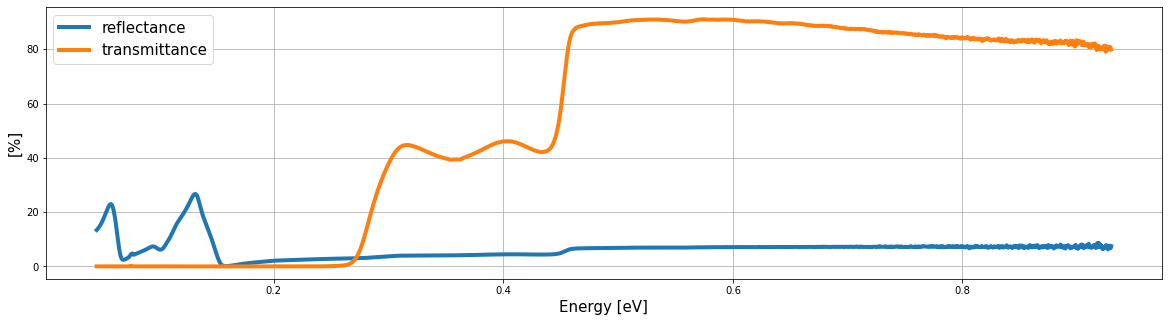

In [3]:
fig = plt.figure(figsize=(20,5))
parcelation = 1 # reducinf number of points
yreflx = reflx_glass.iloc[:,1] / reflx_refr.iloc[:,1] 
yreflx = yreflx[::parcelation]
x = reflx_glass.iloc[:,0]
x = x[::parcelation]
plt.plot(x, yreflx*100, label = 'reflectance', linewidth = 4)

ytrans = trans_glass.iloc[:,1] / trans_refr.iloc[:,1] 
ytrans = ytrans[::parcelation]
plt.plot(x, ytrans*100, label = 'transmittance', linewidth = 4)

plt.xlabel('Energy [eV]', fontsize = 15)
plt.ylabel('[%]', fontsize = 15)
plt.legend(fontsize = 15)
plt.grid()
plt.show()

# Dielectric function

The general form of an oscillator model is given by:
$
\large \varepsilon (\omega) = \varepsilon_{\infty} + \sum_{j} \chi_{j}
$
where
* $\varepsilon$ is the relative permittivity,
* $\varepsilon_{\infty}$ is the value of the relative permittivity at infinite frequency,
* $\omega$ is the angular frequency,
* $\chi_{j}$ is the contribution from the $j$th absorption mechanism oscillator.

Since a glass substrate was investigated here, Lorentzian oscillators were used at the begining. The absorption rise in Transmittance proved to be too abrupt to be described by Lorentzian oscillators, so Brendel-Borman oscillators had to be used.

The Brendel-Bormann oscillator is related to the Lorentzian oscillator ($\chi^{L}$) and Gaussian oscillator ($\chi^{G}$), given by:

$
\large \chi_{j}^{L}(\omega; \omega_{0,j}) = \frac{s_{j}}{\omega_{0,j}^{2} - \omega^{2} - i\Gamma_{j}\omega}
$

$
\large \chi_{j}^{G}(\omega) = \frac{1}{\sqrt{2\pi} \sigma_{j}} \exp \left[-\left(\frac{\omega}{\sqrt{2} \sigma_{j}}\right)^{2}\right]
$

where
* $s_{j}$ is the Lorentzian strength of the $j$th oscillator,
* $\omega_{0,j}$ is the Lorentzian resonant frequency of the $j$th oscillator,
* $\Gamma_{j}$ is the Lorentzian broadening of the $j$th oscillator,
* $\sigma_{j}$ is the Gaussian broadening of the $j$th oscillator.

The Brendel-Bormann oscillator ($\chi^{BB}$) is obtained from the convolution of the two aforementioned oscillators in the manner of:

$
\large \chi_{j}^{BB}(\omega) = \int_{-\infty}^{\infty} \chi_{j}^{G}(x-\omega_{0,j}) \chi_{j}^{L}(\omega; x) \, dx
$

which yields:

$
\large \chi_{j}^{BB}(\omega) = \frac{i \sqrt{\pi} s_{j}}{2 \sqrt{2} \sigma_{j} a_{j}(\omega)} \left[w\left(\frac{a_{j}(\omega) - \omega_{0,j}}{\sqrt{2} \sigma_{j}}\right) + w\left(\frac{a_{j}(\omega) + \omega_{0,j}}{\sqrt{2} \sigma_{j}}\right)\right]
$

where
* $w(z)$ is the Faddeeva function,
* $a_{j} = \sqrt{\omega^2 + i\Gamma_{j}\omega}$.

The square root in the definition of $a_{j}$ must be taken such that its imaginary component is positive. This is achieved by:

$
\large \Re(a_{j}) = \omega \sqrt{\frac{\sqrt{1 + (\Gamma_{j}/\omega)^{2}} + 1}{2}}
$

$
\large \Im(a_{j}) = \omega \sqrt{\frac{\sqrt{1 + (\Gamma_{j}/\omega)^{2}} - 1}{2}}
$

https://en.wikipedia.org/wiki/Brendel%E2%80%93Bormann_oscillator_model

In [4]:
def hobb(param,Energ):
    #  Dielectric function calculation - Harmonic Oscilator Brendel, Bormann
    #  input parameters:  vector [A, E0, Gamma, Sigma]
    #      E - photon energy [eV]
    # output parameters:  Complex dielectric function 
    #                           - vector corresponding to Energy
    #                           - imaginary part is negative
    param = np.array(param[:-2])
    num_oscilators = int(len(param)/4)
    param = param.reshape(num_oscilators,4).transpose() 
    Energ = np.array(Energ)
    Energ = np.tile(Energ, (num_oscilators,1)).transpose()
    A=param[0]
    E0=param[1]
    Γ=param[2]
    σ=param[3]
    π = pi
    
    ak = sqrt(Energ**2+1j*Energ*Γ)
    ak[ak == 1j*0] = 0.000001*1j
    assert (imag(ak)>0).all
    result = 1j*sqrt(pi/2)*A/2/σ/ak
    permitivity = result * (wofz((ak-E0)/sqrt(2)/σ) + wofz((ak+E0)/sqrt(2)/σ))
    permitivity = np.sum(permitivity, axis =1)
    return permitivity


# Transmittance and Reflectance of thick layer

Considering internal reflection in a thick layer we can write Transmittance as:

$ \Large T^{(012)} = \frac{T^{(01)}T^{(12)}e^{-2k_0 \Im(n) d}}{1 - R^{(01)}R^{(10)}e^{-4 k_0 \Im(n) d}} $

and Reflectance as:

$ \Large R^{(012)} = R^{(01)} + \frac{T^{(01)}R^{(12)}T^{(10)}e^{-4k_{0} \Im(n) d}}{1 - R^{(01)}R^{(10)}e^{-4k_0 \Im(n) d}} $

where T and R are Reflectance and Transmittance on interface obtained from Fresnel coefficients

In [5]:
def thick_layer_hobb(p, energy, R, T):
    Rdiff = thick_reflect_hobb(energy, p) - R
    Tdiff = thick_trans_hobb(energy, p) - T
    return np.concatenate((Tdiff, Rdiff))

def thick_reflect_hobb(energy, p):
    d = p[-1]
    epsilon_inf = p[-2]
    epsilon = hobb(p, energy) + epsilon_inf
    n_glass = np.sqrt(epsilon)
    extinct = np.imag(n_glass)
    refractive = np.real(n_glass)
    R_01 = square(abs((1 - n_glass)/(1 + n_glass)))
    R_12 = square(abs((n_glass - 1)/(n_glass + 1)))
    T_01 = square(abs(2/(1+n_glass)))
    T_10 = square(abs(2*n_glass/(1+n_glass)))
    wavelength = h * c / energy / e
    exponent = exp(-8*pi/wavelength*extinct*d)
    return R_01 + T_01*R_12*T_10*exponent/(1-square(R_12)*exponent)

def thick_trans_hobb(energy, p):
    d = p[-1]
    epsilon_inf = p[-2]
    epsilon = hobb(p, energy) + epsilon_inf
    n_glass = np.sqrt(epsilon)
    extinct = np.imag(n_glass)
    refractive = np.real(n_glass)
    R_12 = square(abs((n_glass - 1)/(n_glass + 1)))
    T_01 = square(abs(2/(1+n_glass)))
    T_12 = square(abs(2*n_glass/(1+n_glass)))
    wavelength = h * c / energy / e
    exponent1 = exp(-4*pi/wavelength*extinct*d)
    exponent2 = exp(-8*pi/wavelength*extinct*d)
    Trans = T_01*T_12*exponent1/(1-square(R_12)*exponent2) 
    return Trans

# Fitting substrate

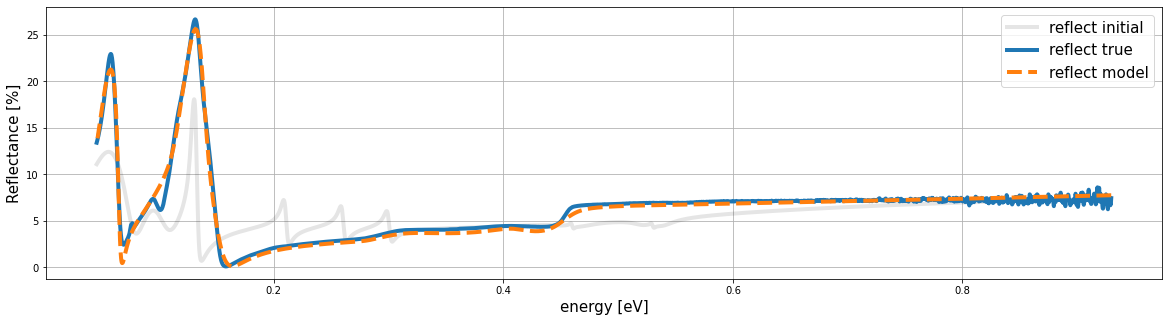

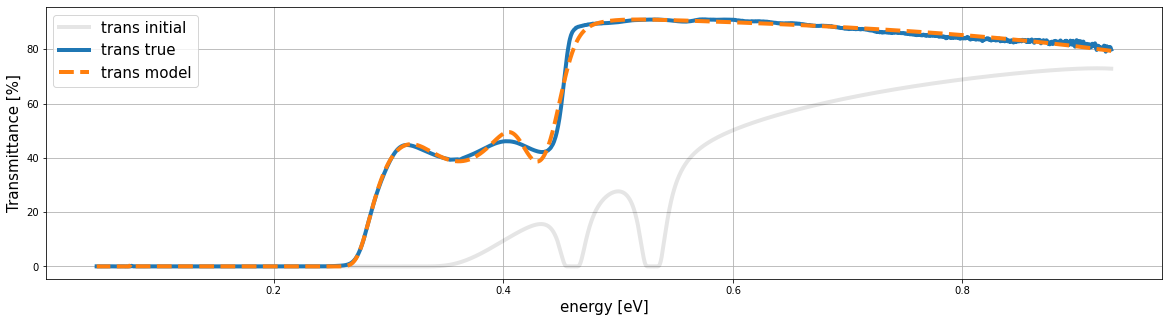

,A,E_0,$\Gamma$,$\sigma$
0,1.79e-03,5.73e-02,2.69e-11,4.56e-03
1,3.87e-03,1.27e-01,3.21e-11,5.67e-03
2,3.05e-06,3.62e-01,9.10e-08,4.38e-02
3,5.42e-05,2.20e-01,5.59e-05,2.26e-02
4,2.24e-06,2.68e-01,1.59e-03,2.78e-02
5,2.28e-07,2.11e-01,2.74e-05,5.04e-03
6,4.57e-03,1.32e-01,3.63e-11,1.50e-02
7,6.88e-07,4.32e-01,2.78e-12,1.38e-02
8,1.10e-09,2.08e-03,1.08e-02,1.45e+00
9,9.68e-01,1.49e+00,1.62e-05,4.45e-02


substrate thickness = 5.61 mm
Ɛ∞ =                  1.68


cost:                 0.34
numer of evaluations: 143
time of fit:          142 s


In [6]:
init_params = []
init_params.extend([0.001,0.06,0.001,0.008,
                    0.001,0.07,0.001,0.008,
                    0.001,0.10,0.001,0.008,
                    0.002,0.13,0.004,0.0008,
                    0.001,0.21,0.004,0.0008,
                    0.001,0.26,0.004,0.0008,
                    0.001,0.3,0.004,0.0008,
                    0.0001,0.46,0.0009,0.0008,
                    0.0001,0.53,0.0009,0.0008,
                    0.0001,1,0.0009,0.0008,
                   ])
epsilon_inf = 2.4
init_params.append(epsilon_inf)
d = 0.002
init_params.append(d)


upper_bounds = np.full(len(init_params)-1, np.inf)
lower_bounds = np.zeros(len(init_params)-1)
bounds = [(np.append(lower_bounds,(0.0005))),(np.append(upper_bounds,(0.6)))]

from scipy.optimize import least_squares
start_time = time.time()
thick_res = least_squares(thick_layer_hobb,x0=init_params, args=(x, yreflx, ytrans), bounds = bounds, max_nfev = 1000)
end_time = time.time()

#plotting reflectance
fig = plt.figure(figsize=(20,5))
plt.plot(x, thick_reflect_hobb(x,init_params)*100, label='reflect initial', alpha=0.1, color='black', linewidth = 4)
plt.plot(x, yreflx*100, label='reflect true', linewidth = 4)
plt.plot(x, thick_reflect_hobb(x,thick_res.x)*100, label = 'reflect model', linestyle = 'dashed', linewidth = 4)
plt.xlabel('energy [eV]', fontsize = 15)
plt.ylabel('Reflectance [%]', fontsize = 15)
plt.legend(fontsize=15)
plt.grid()
plt.show()

#plotting transmittance
fig = plt.figure(figsize=(20,5))
plt.plot(x, thick_trans_hobb(x,init_params)*100,label='trans initial', alpha=0.1, color = 'black', linewidth = 4)
plt.plot(x, ytrans*100, label='trans true', linewidth = 4)
plt.plot(x, thick_trans_hobb(x,thick_res.x)*100, label = 'trans model',linestyle = 'dashed', linewidth = 4)
plt.xlabel('energy [eV]', fontsize = 15)
plt.ylabel('Transmittance [%]', fontsize = 15)
plt.legend(fontsize=15)
plt.grid()
plt.show()

data = thick_res.x[:-2]

# Display fitted parameters
data = data.reshape(-1, 4)
df = pd.DataFrame(data, columns=["A", "E_0", "$\Gamma$", "$\sigma$"])
pd.set_option('display.float_format', '{:.2e}'.format)
display(df)
print('substrate thickness = ' + str(round(thick_res.x[-1]*1000, 2)) + ' mm')
print("Ɛ∞ =                  " + str(round(thick_res.x[-2], 2)) )
print('\n')
print('cost:                 ' + str(round(thick_res.cost, 2)))
print('numer of evaluations: ' + str(thick_res.nfev))
print('time of fit:          ' + str(round(end_time - start_time)) + ' s')


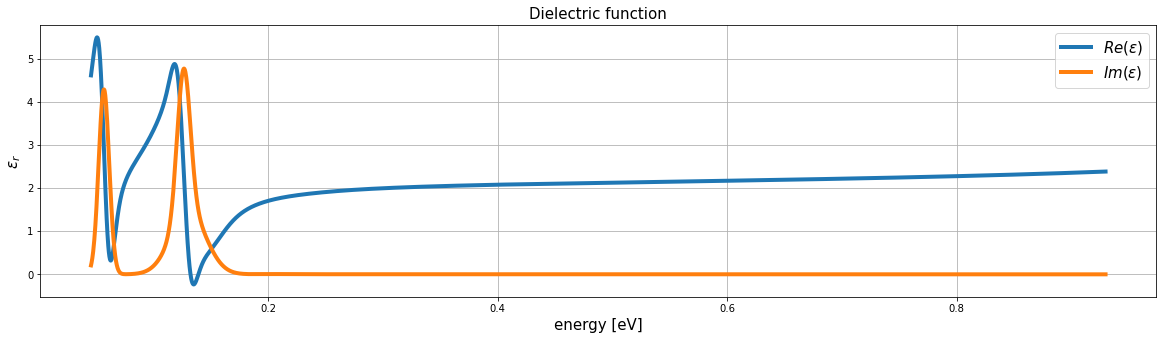

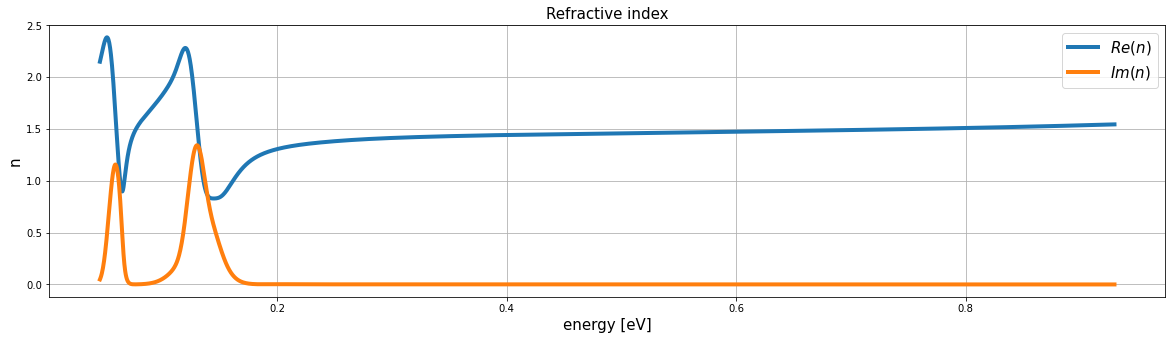

In [7]:
epsilon = hobb(thick_res.x, x) + thick_res.x[-2]
n_glass = sqrt(epsilon)

#plotting dielectric function
fig = plt.figure(figsize=(20,5))
plt.plot(x, np.real(epsilon), label='$Re(\epsilon)$', linewidth = 4)
plt.plot(x, np.imag(epsilon), label='$Im(\epsilon)$', linewidth = 4)
plt.legend(fontsize = 15)
plt.grid()
plt.xlabel("energy [eV]", fontsize = 15)
plt.ylabel("$\epsilon_r$", fontsize = 15)
plt.title('Dielectric function', fontsize = 15)
plt.savefig('Dielectric.png')

# plotting refractive index
fig = plt.figure(figsize=(20,5))
plt.plot(x, np.real(n_glass), label='$Re(n)$', linewidth = 4)
plt.plot(x, np.imag(n_glass), label='$Im(n)$', linewidth = 4)
plt.legend(fontsize = 15)
plt.grid()
plt.xlabel("energy [eV]", fontsize = 15)
plt.ylabel("n", fontsize = 15)
plt.title('Refractive index', fontsize = 15)
plt.savefig('Refractive.png')

# Thin layer functions

In [8]:
def r_interference(p, energy):
    d_rez = p[-1]
    epsilon_inf = p[-2]
    n_rez = np.conj(sqrt(hobb(p,energy) + epsilon_inf))
    n_glass = np.sqrt(epsilon)[:len(energy)]
    wavelength = h * c / energy / e
    
    r_01 = (n_rez - 1)/(n_rez+1)
    r_12 = (n_glass - n_rez)/(n_glass+n_rez)
    Reflection = np.square(np.abs((r_01+r_12*exp(-4j*pi/wavelength*n_rez*d_rez))/(1 + r_01*r_12*exp(-4j*pi/wavelength*n_rez*d_rez))))
    return Reflection

def r_interference_back(p, energy):
    d_rez = p[-1]
    epsilon_inf = p[-2]
    n_rez = np.conj(sqrt(hobb(p,energy) + epsilon_inf))
    n_glass = np.sqrt(epsilon)[:len(energy)]
    wavelength = h * c / energy / e
    
    r_01 = (n_rez - n_glass)/(n_glass+n_rez)
    r_12 = (1 - n_rez)/(n_rez+1)
    Reflection = np.square(np.abs((r_01+r_12*exp(-4j*pi/wavelength*n_rez*d_rez))/(1 + r_01*r_12*exp(-4j*pi/wavelength*n_rez*d_rez))))
    return Reflection

def t_interference(p, energy):
    d_rez = p[-1]
    epsilon_inf = p[-2]
    n_rez = np.conj(sqrt(hobb(p,energy) + epsilon_inf))
    n_glass = np.sqrt(epsilon)[:len(energy)]
    wavelength = h * c / energy / e
    extinct = imag(n_rez)
    
    r_01 = (1 - n_rez)/(n_rez+1)
    r_12 = (n_rez - n_glass)/(n_glass+n_rez)
    t_01 = 2/(n_rez+1)
    t_12 = 2*n_rez/(n_rez+n_glass)
    
    
    T = np.square(np.abs((t_01*t_12*exp(-2j*pi/wavelength*n_rez*d_rez))/(1 + r_01*r_12*exp(-4j*pi/wavelength*n_rez*d_rez))))
    return T

def t_interference_back(p, energy):
    d_rez = p[-1]
    epsilon_inf = p[-2]
    n_rez = np.conj(sqrt(hobb(p,energy) + epsilon_inf))
    n_glass = np.sqrt(epsilon)[:len(energy)]
    wavelength = h * c / energy / e
    extinct = imag(n_rez)
    
    r_01 = (1 - n_rez)/(n_rez+1)
    r_12 = (n_rez - n_glass)/(n_glass+n_rez)
    t_01 = 2*n_glass/(n_glass+n_rez)
    t_12 = 2*n_rez/(n_rez+1)
    
    
    T = np.square(np.abs((t_01*t_12*exp(-2j*pi/wavelength*n_rez*d_rez))/(1 + r_01*r_12*exp(-4j*pi/wavelength*n_rez*d_rez))))
    return T

def r_substrate(p, energy):
    d_sub = substrate_thickness
    d_rez = p[-1]
    epsilon_inf = p[-2]
    n_rez = sqrt(hobb(p,energy) + epsilon_inf)
    
    n_glass = np.sqrt(epsilon)[:len(energy)]
    extinct = np.imag(n_glass)
    wavelength = h * c / energy / e
    
    R_01 = r_interference(p, energy)
    R_10 = r_interference_back(p, energy)
    R_12 = square(abs((n_glass - 1)/(n_glass + 1)))
    T_01 = t_interference(p, energy)
    T_10 = t_interference_back(p, energy)
    exponent = exp(-4*pi/wavelength*extinct*d_sub)
    
    return R_01 + T_01*R_12*T_10*exponent/(1-R_12*R_10*exponent)

def t_substrate(p, energy):
    d_sub = substrate_thickness
    d_rez = p[-1]
    epsilon_inf = p[-2]
    n_rez = sqrt(hobb(p,energy) + epsilon_inf)
    
    wavelength = h * c / energy / e
    n_glass = np.sqrt(epsilon)[:len(energy)]
    extinct = np.imag(n_glass)
    
    R_10 = r_interference_back(p, energy)
    R_12 = square(abs((n_glass - 1)/(n_glass + 1)))
    T_01 = t_interference(p, energy)
    T_12 = square(abs(2*n_glass/(1+n_glass)))
    exponent1 = exp(-4*pi/wavelength*extinct*d_sub)
    exponent2 = exp(-8*pi/wavelength*extinct*d_sub)
    
    Trans = T_01*T_12*exponent1/(1-R_12*R_10*exponent2)
    return Trans

def fit_both(p, energy, R1, T1, R2, T2, R3, T3, R4, T4):
    p1 = np.append(p[:-4], p[-4])
    p2 = np.append(p[:-4], p[-3])
    p3 = np.append(p[:-4], p[-2])
    p4 = np.append(p[:-4], p[-1])
    Rdiff1 = r_substrate(p1, energy) - R1
    Tdiff1 = t_substrate(p1, energy) - T1
    Rdiff2 = r_substrate(p2, energy) - R2
    Tdiff2 = t_substrate(p2, energy) - T2
    Rdiff3 = r_substrate(p3, energy) - R3
    Tdiff3 = t_substrate(p3, energy) - T3
    Rdiff4 = r_substrate(p4, energy) - R4
    Tdiff4 = t_substrate(p4, energy) - T4
    both = np.concatenate((Tdiff1, Rdiff1, Tdiff2, Rdiff2, Tdiff3, Rdiff3, Tdiff4, Rdiff4))
    return both

# Fitting thin layer

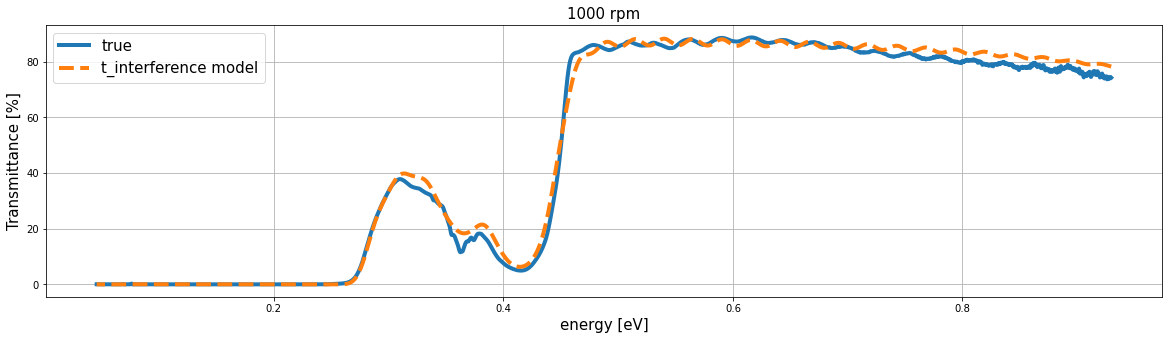

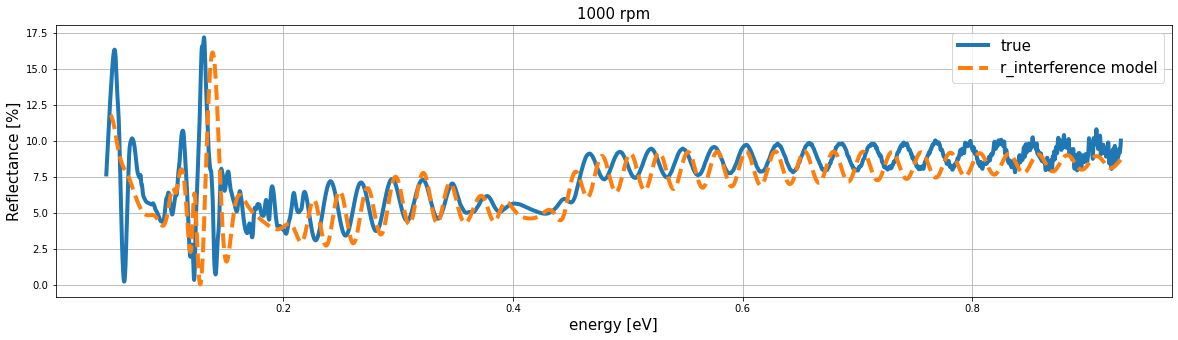

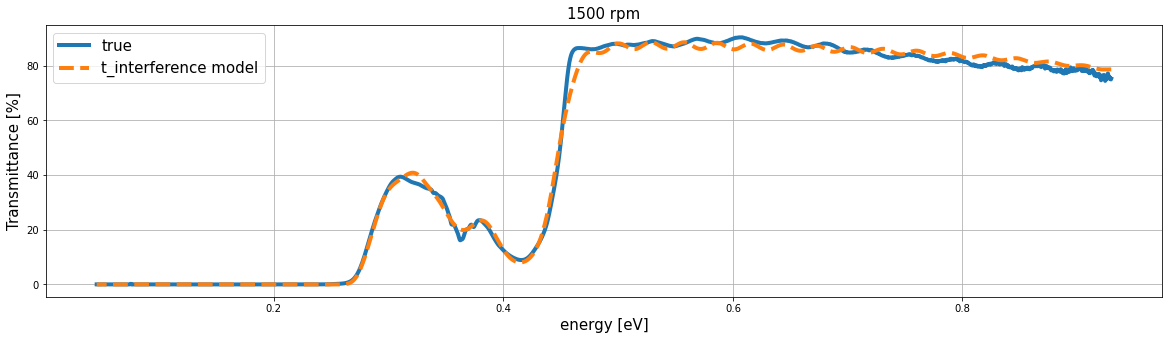

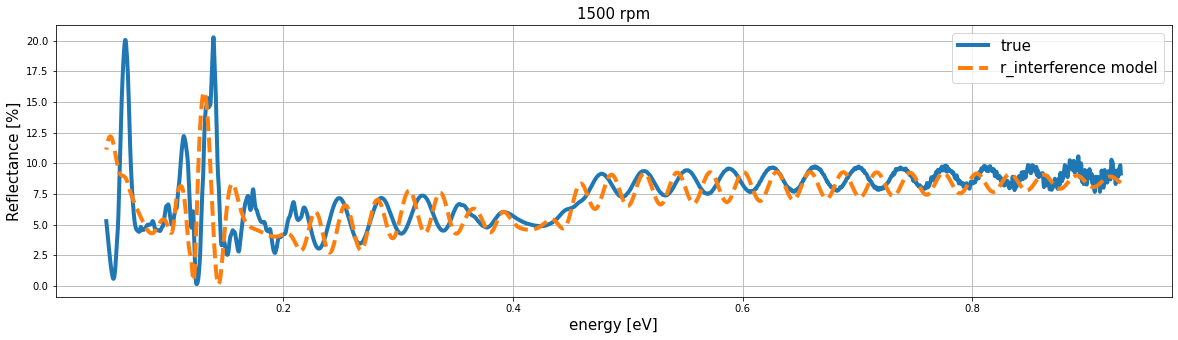

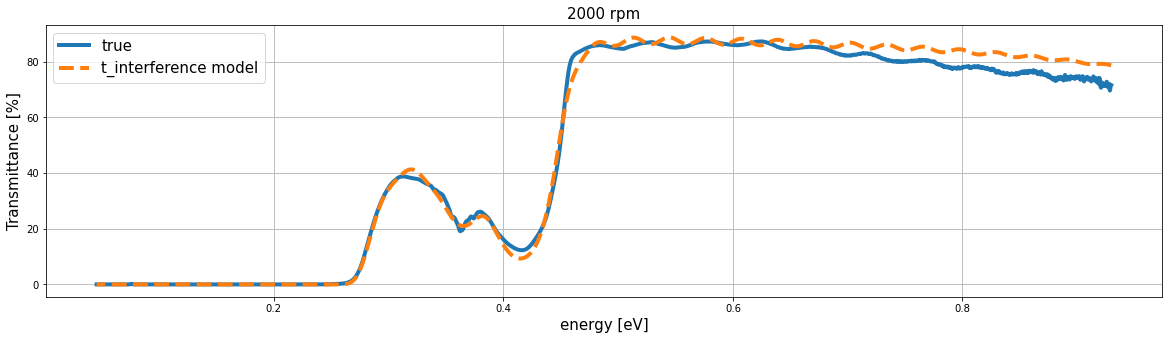

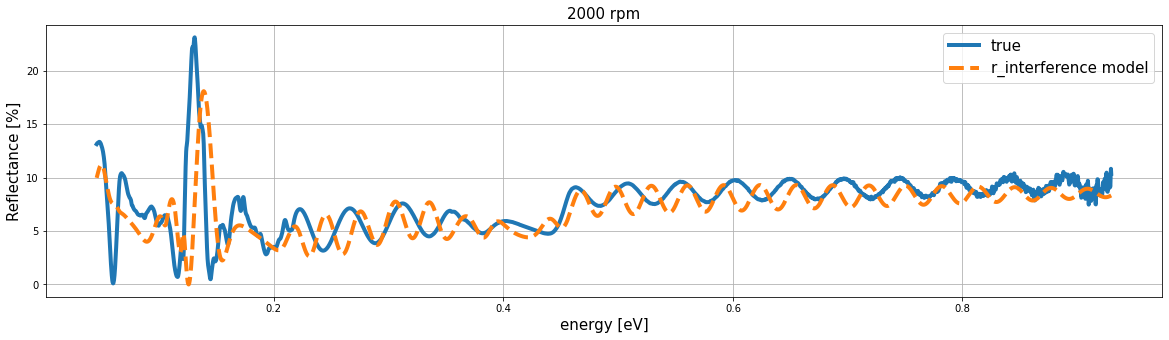

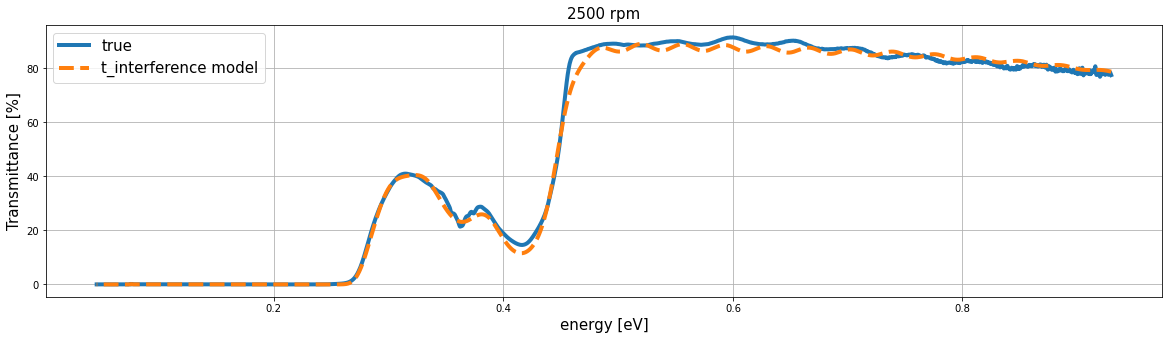

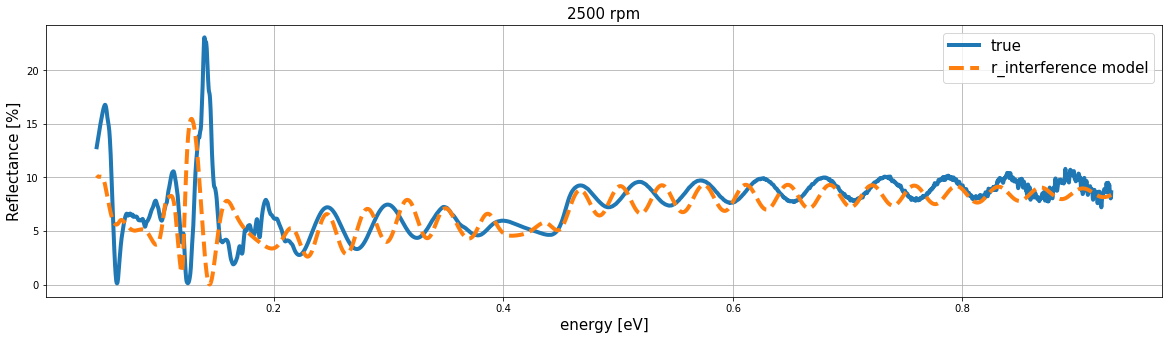

In [9]:
substrate_thickness = thick_res.x[-1]
epsilon_inf_substrate = thick_res.x[-2]

d = np.array([10e-6, 12e-6, 14e-6, 16e-6])# initial guess for glass thicknes
inter_params = [] 
inter_params.extend([0.0001,0.06,0.01,0.008,
                     0.0001,0.07,0.01,0.008,
                     0.0001,0.08,0.01,0.008,
                     0.0001,0.09,0.01,0.008,
                     0.0001,0.10,0.01,0.008,
                     0.0001,0.11,0.01,0.008,
                     0.0001,0.13,0.01,0.008,
                     0.01,0.4,0.01,0.0008,
                     0.005,0.05,0.01,0.08,])
epsilon_inf = 2.4
inter_params.append(epsilon_inf)
inter_params.extend(d)
arguments = [x]
truth = []
for sample in range(4):
    inter_trans = pd.read_csv(trans_data[sample]).iloc[:,1][:]  / trans_refr.iloc[:,1][:] 
    inter_trans = inter_trans[::parcelation]
    inter_reflx = pd.read_csv(reflx_data[sample]).iloc[:,1][:]  / reflx_refr.iloc[:,1][:] 
    inter_reflx = inter_reflx[::parcelation]
    truth.append([inter_reflx, inter_trans])
    arguments.extend([inter_reflx, inter_trans])

upper_bounds = np.full(len(inter_params)-1, np.inf)
lower_bounds = np.zeros(len(inter_params)-1)
bounds = [(np.append(lower_bounds,(1e-6))),(np.append(upper_bounds,(0.6)))]


from scipy.optimize import least_squares
thin_res = least_squares(fit_both,x0=inter_params, args=arguments, max_nfev = 1000, bounds = bounds)
n_rez = sqrt(hobb(inter_params[:-3],x)+inter_params[-4])

rpms = [1000, 1500, 2000, 2500]


for sample in range(4):
    inter_reflx, inter_trans = truth[sample]

    inter_init = np.append(inter_params[:-4], d[-sample-1])
    inter_fit = np.append(thin_res.x[:-4], thin_res.x[-sample-1])
    
    fig = plt.figure(figsize=(20,5))
    #plt.plot(x, t_substrate(inter_init, x)*100 , label='t_interference init', color='black', alpha=0.6)
    plt.plot(x, inter_trans*100, label='true', linewidth = 4)
    plt.plot(x, t_substrate(inter_fit, x)*100, label = 't_interference model', linestyle = 'dashed', linewidth = 4)
    plt.xlabel('energy [eV]', fontsize = 15)
    plt.ylabel('Transmittance [%]', fontsize = 15)
    plt.title(str(rpms[sample]) + ' rpm', fontsize = 15)
    plt.legend(fontsize=15)
    plt.grid()

    fig = plt.figure(figsize=(20,5))
    #plt.plot(x, r_substrate(inter_init, x)*100 , label='r_interference init', color='black', alpha=0.6)
    plt.plot(x, inter_reflx*100, label='true', linewidth = 4)
    plt.plot(x, r_substrate(inter_fit, x)*100, label = 'r_interference model', linestyle = 'dashed', linewidth = 4)
    plt.xlabel('energy [eV]', fontsize = 15)
    plt.ylabel('Reflectance [%]', fontsize = 15)
    plt.title(str(rpms[sample]) + ' rpm', fontsize = 15)
    plt.legend(fontsize=15)
    plt.grid()

14.119999999999806


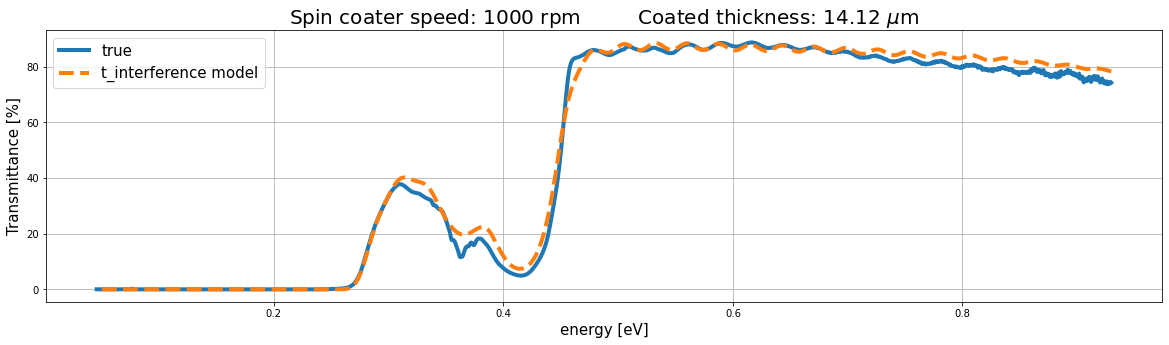

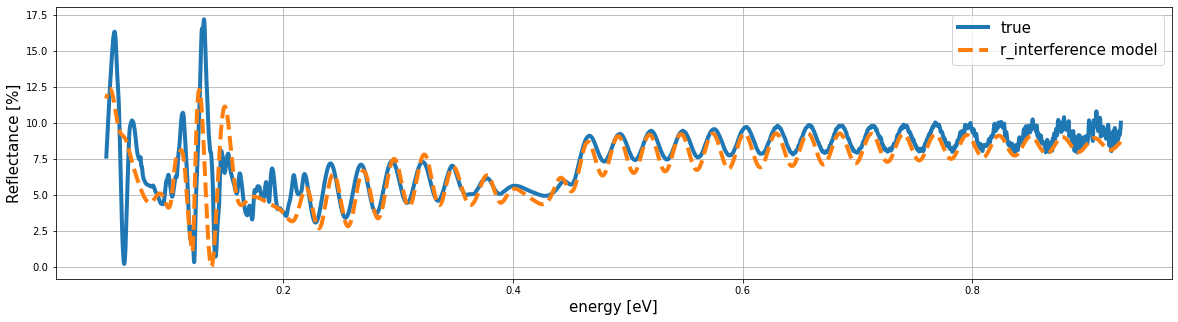

10.429999999999884


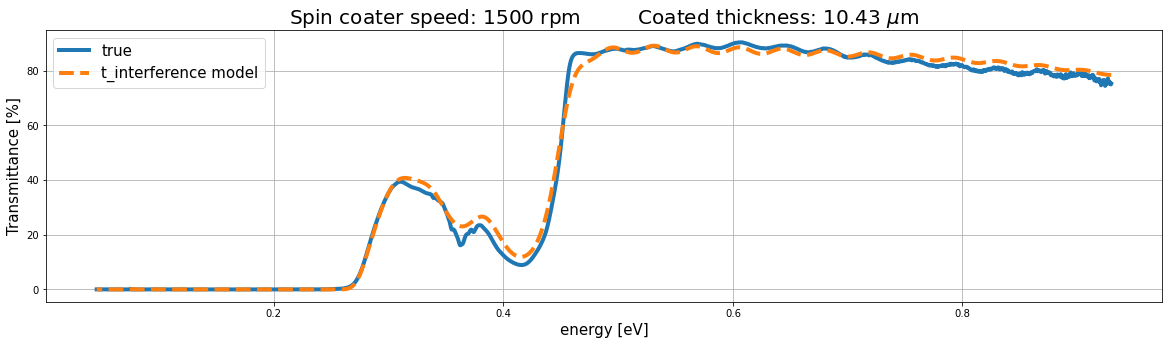

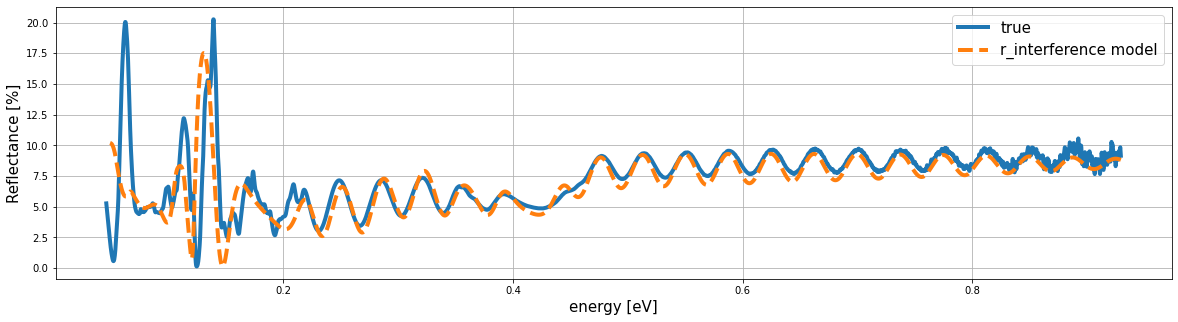

8.219999999999931


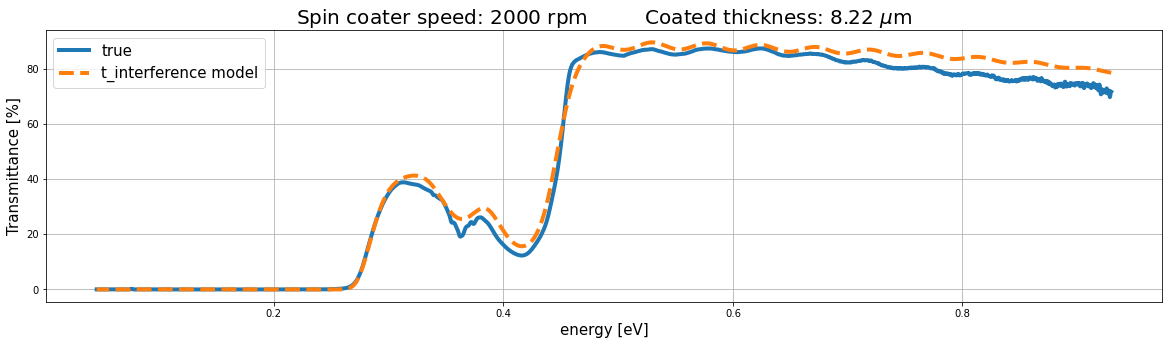

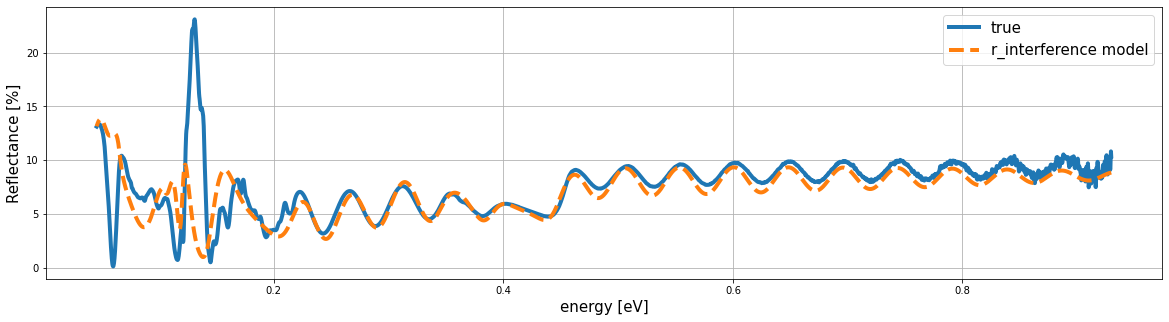

7.269999999999952


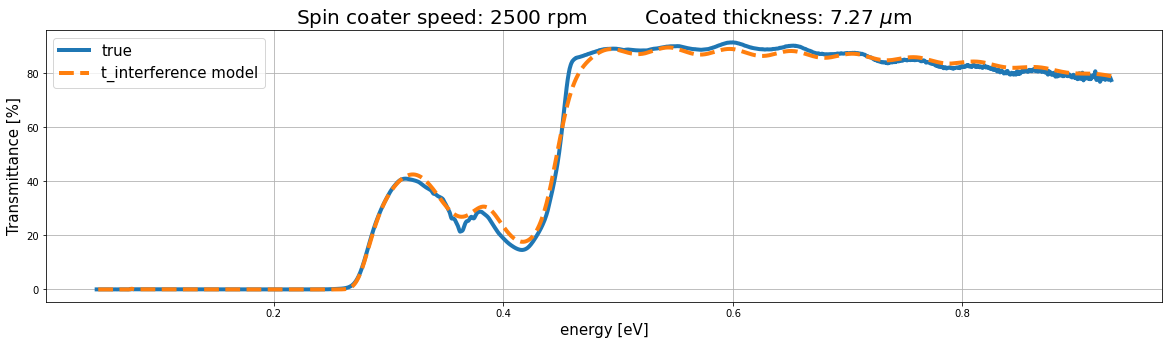

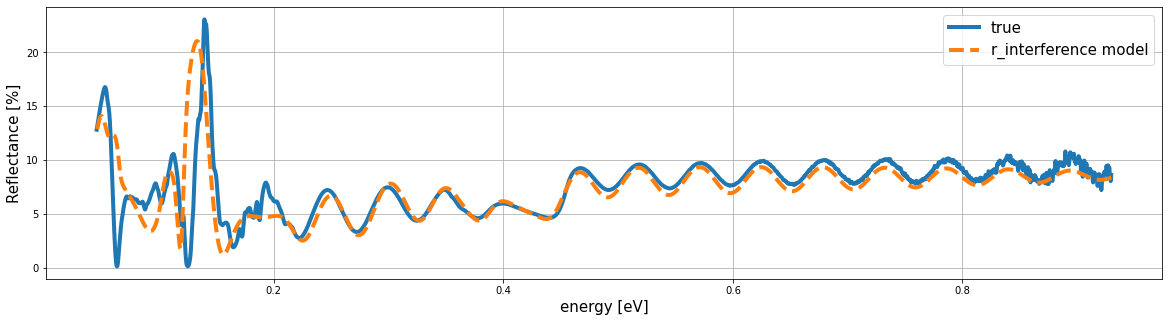

Text(0.5, 0, 'rpms')

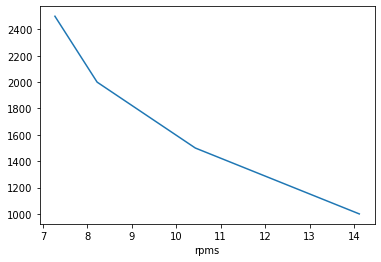

In [10]:
thicknesses = []
for sample in range(4):
    inter_reflx, inter_trans = truth[sample]

    inter_init = np.append(inter_params[:-4], d[-sample-1])
    best_difference = np.inf
    best_thickness = 0
    for i in np.arange(5,30,0.01):
        inter_fit = np.append(thin_res.x[:-4], i*1e-6)
        difference = sum(np.square(r_substrate(inter_fit, x)[:3100] - inter_reflx[:3100]))
        if difference < best_difference:
            best_difference = difference
            best_thickness = i
    
    print(best_thickness)
    thicknesses.append(best_thickness)
    
    inter_fit = np.append(thin_res.x[:-4], best_thickness*1e-6)
    fig = plt.figure(figsize=(20,5))
    #plt.plot(x, t_substrate(inter_init, x)*100 , label='t_interference init', color='black', alpha=0.6)
    plt.plot(x, inter_trans*100, label='true', linewidth = 4)
    plt.plot(x, t_substrate(inter_fit, x)*100, label = 't_interference model', linestyle = 'dashed', linewidth = 4)
    plt.xlabel('energy [eV]', fontsize = 15)
    plt.ylabel('Transmittance [%]', fontsize = 15)
    plt.title('Spin coater speed: ' + str(rpms[sample]) + ' rpm         Coated thickness: ' + str(round(best_thickness, 2)) + ' $\mu$m', fontsize = 20)
    plt.legend(fontsize=15)
    plt.grid()
    plt.show()


    fig = plt.figure(figsize=(20,5))
    #plt.plot(x, r_substrate(inter_init, x)*100 , label='r_interference init', color='black', alpha=0.6)
    plt.plot(x, inter_reflx*100, label='true', linewidth = 4)
    plt.plot(x, r_substrate(inter_fit, x)*100, label = 'r_interference model', linestyle = 'dashed', linewidth = 4)
    plt.xlabel('energy [eV]', fontsize = 15)
    plt.ylabel('Reflectance [%]', fontsize = 15)
    plt.legend(fontsize=15)
    plt.grid()
    plt.show()
    
plt.plot(thicknesses, rpms)
plt.xlabel('rpms')

In [11]:
def r_interference(p, energy, d_rez):
    #d_rez = p[-1]
    epsilon_inf = p[-2]
    n_rez = np.conj(sqrt(hobb(p,energy) + epsilon_inf))
    n_glass = np.sqrt(epsilon)[:len(energy)]
    wavelength = h * c / energy / e
    
    r_01 = (n_rez - 1)/(n_rez+1)
    r_12 = (n_glass - n_rez)/(n_glass+n_rez)
    Reflection = np.square(np.abs((r_01+r_12*exp(-4j*pi/wavelength*n_rez*d_rez))/(1 + r_01*r_12*exp(-4j*pi/wavelength*n_rez*d_rez))))
    return Reflection

def r_interference_back(p, energy, d_rez):
    #d_rez = p[-1]
    epsilon_inf = p[-2]
    n_rez = np.conj(sqrt(hobb(p,energy) + epsilon_inf))
    n_glass = np.sqrt(epsilon)[:len(energy)]
    wavelength = h * c / energy / e
    
    r_01 = (n_rez - n_glass)/(n_glass+n_rez)
    r_12 = (1 - n_rez)/(n_rez+1)
    Reflection = np.square(np.abs((r_01+r_12*exp(-4j*pi/wavelength*n_rez*d_rez))/(1 + r_01*r_12*exp(-4j*pi/wavelength*n_rez*d_rez))))
    return Reflection

def t_interference(p, energy, d_rez):
    #d_rez = p[-1]
    epsilon_inf = p[-2]
    n_rez = np.conj(sqrt(hobb(p,energy) + epsilon_inf))
    n_glass = np.sqrt(epsilon)[:len(energy)]
    wavelength = h * c / energy / e
    extinct = imag(n_rez)
    
    r_01 = (1 - n_rez)/(n_rez+1)
    r_12 = (n_rez - n_glass)/(n_glass+n_rez)
    t_01 = 2/(n_rez+1)
    t_12 = 2*n_rez/(n_rez+n_glass)
    
    
    T = np.square(np.abs((t_01*t_12*exp(-2j*pi/wavelength*n_rez*d_rez))/(1 + r_01*r_12*exp(-4j*pi/wavelength*n_rez*d_rez))))
    return T

def t_interference_back(p, energy, d_rez):
    #d_rez = p[-1]
    epsilon_inf = p[-2]
    n_rez = np.conj(sqrt(hobb(p,energy) + epsilon_inf))
    n_glass = np.sqrt(epsilon)[:len(energy)]
    wavelength = h * c / energy / e
    extinct = imag(n_rez)
    
    r_01 = (1 - n_rez)/(n_rez+1)
    r_12 = (n_rez - n_glass)/(n_glass+n_rez)
    t_01 = 2*n_glass/(n_glass+n_rez)
    t_12 = 2*n_rez/(n_rez+1)
    
    
    T = np.square(np.abs((t_01*t_12*exp(-2j*pi/wavelength*n_rez*d_rez))/(1 + r_01*r_12*exp(-4j*pi/wavelength*n_rez*d_rez))))
    return T

def r_substrate(p, energy, d_rez):
    d_sub = substrate_thickness
    #d_rez = p[-1]
    epsilon_inf = p[-2]
    n_rez = sqrt(hobb(p,energy) + epsilon_inf)
    
    n_glass = np.sqrt(epsilon)[:len(energy)]
    extinct = np.imag(n_glass)
    wavelength = h * c / energy / e
    
    R_01 = r_interference(p, energy, d_rez)
    R_10 = r_interference_back(p, energy, d_rez)
    R_12 = square(abs((n_glass - 1)/(n_glass + 1)))
    T_01 = t_interference(p, energy, d_rez)
    T_10 = t_interference_back(p, energy, d_rez)
    exponent = exp(-4*pi/wavelength*extinct*d_sub)
    
    return R_01 + T_01*R_12*T_10*exponent/(1-R_12*R_10*exponent)

def t_substrate(p, energy, d_rez):
    d_sub = substrate_thickness
    #d_rez = p[-1]
    epsilon_inf = p[-2]
    n_rez = sqrt(hobb(p,energy) + epsilon_inf)
    
    wavelength = h * c / energy / e
    n_glass = np.sqrt(epsilon)[:len(energy)]
    extinct = np.imag(n_glass)
    
    R_10 = r_interference_back(p, energy, d_rez)
    R_12 = square(abs((n_glass - 1)/(n_glass + 1)))
    T_01 = t_interference(p, energy, d_rez)
    T_12 = square(abs(2*n_glass/(1+n_glass)))
    exponent1 = exp(-4*pi/wavelength*extinct*d_sub)
    exponent2 = exp(-8*pi/wavelength*extinct*d_sub)
    
    Trans = T_01*T_12*exponent1/(1-R_12*R_10*exponent2)
    return Trans

def fit_both(p, energy, R1, T1, d1, R2, T2, d2, R3, T3, d3, R4, T4, d4):
    p1 = np.append(p[:-4], p[-4])
    p2 = np.append(p[:-4], p[-3])
    p3 = np.append(p[:-4], p[-2])
    p4 = np.append(p[:-4], p[-1])
    Rdiff1 = r_substrate(p1, energy, d1) - R1
    Tdiff1 = t_substrate(p1, energy, d1) - T1
    Rdiff2 = r_substrate(p2, energy, d2) - R2
    Tdiff2 = t_substrate(p2, energy, d2) - T2
    Rdiff3 = r_substrate(p3, energy, d3) - R3
    Tdiff3 = t_substrate(p3, energy, d3) - T3
    Rdiff4 = r_substrate(p4, energy, d4) - R4
    Tdiff4 = t_substrate(p4, energy, d4) - T4
    both = np.concatenate((Tdiff1, Rdiff1, Tdiff2, Rdiff2, Tdiff3, Rdiff3, Tdiff4, Rdiff4))
    return both

,A,E_0,$\Gamma$,$\sigma$
0,4.35e-04,5.75e-02,1.02e-31,2.85e-03
1,2.60e-02,4.78e-04,3.35e+01,4.75e-04
2,3.04e-34,8.31e-02,2.24e-04,2.21e-02
3,1.46e-33,6.79e-02,1.03e-02,5.34e-02
4,1.79e-03,8.48e-02,3.59e-35,1.07e-01
5,1.64e-03,1.14e-01,9.43e-34,7.15e-03
6,6.38e-04,3.72e-01,1.27e-41,2.31e-02
7,1.14e-03,4.15e-01,1.07e-44,1.49e-02
8,3.48e-04,1.69e-01,6.07e-40,1.17e-02


Ɛ∞ =                  2.48


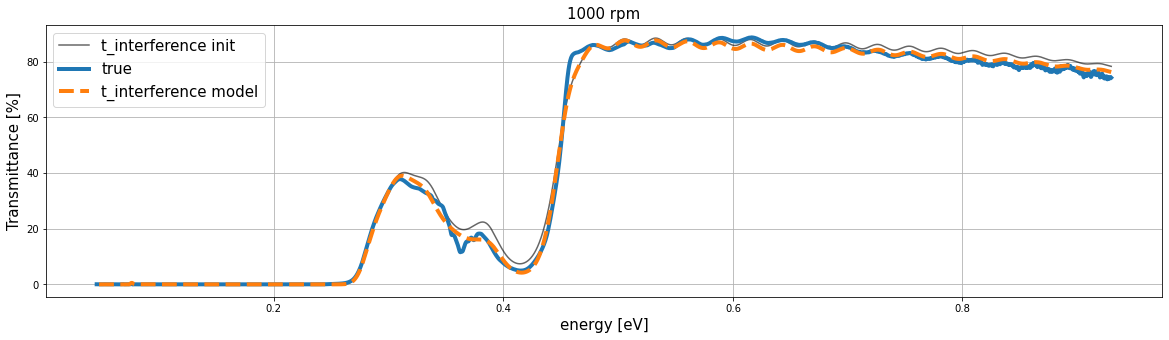

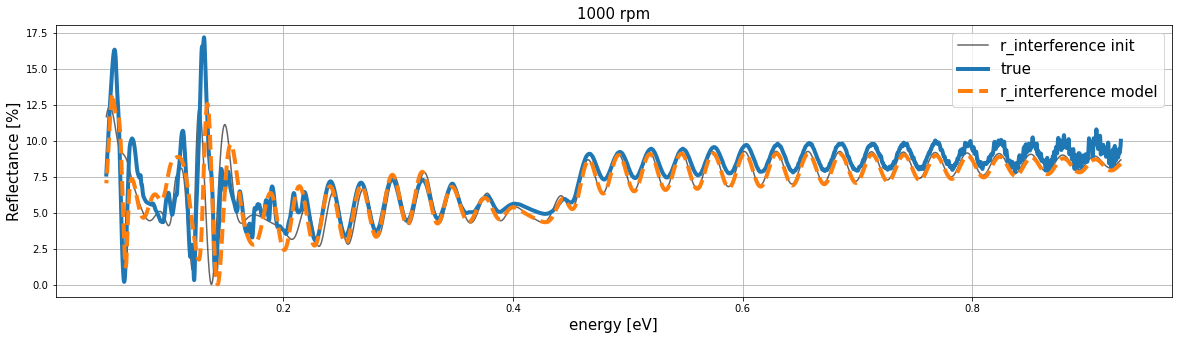

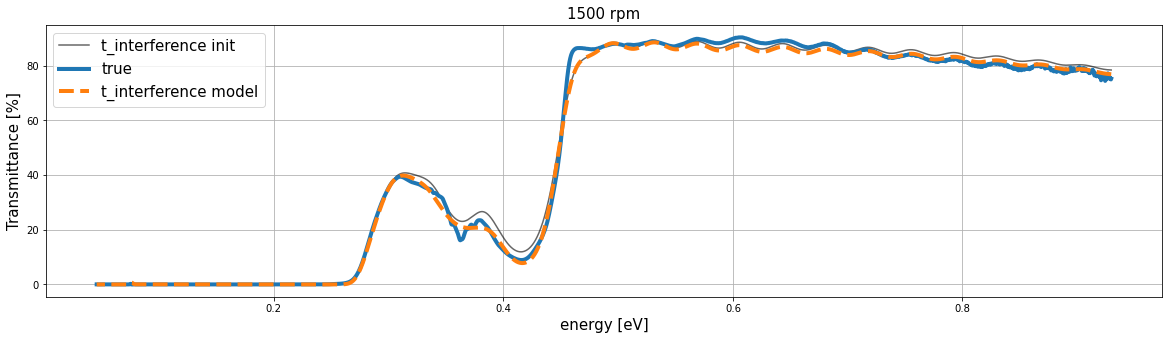

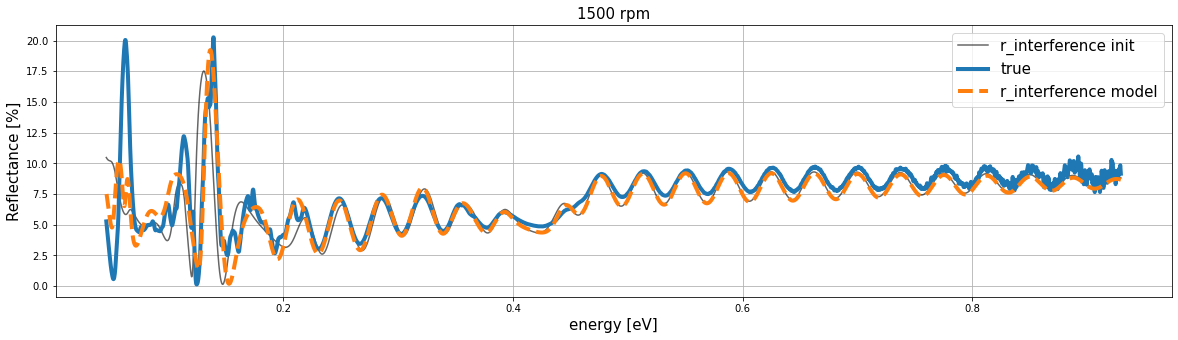

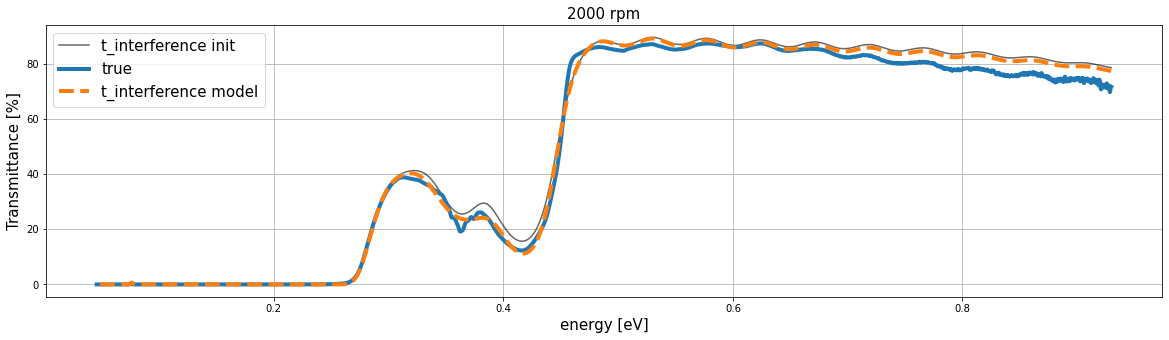

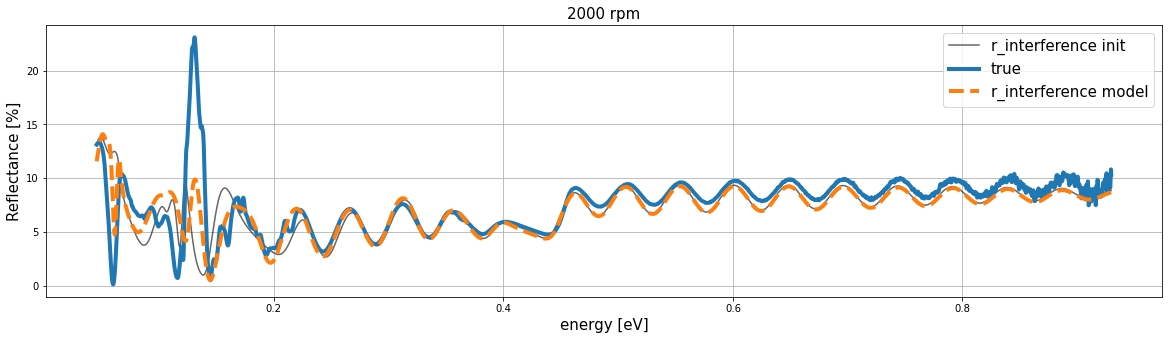

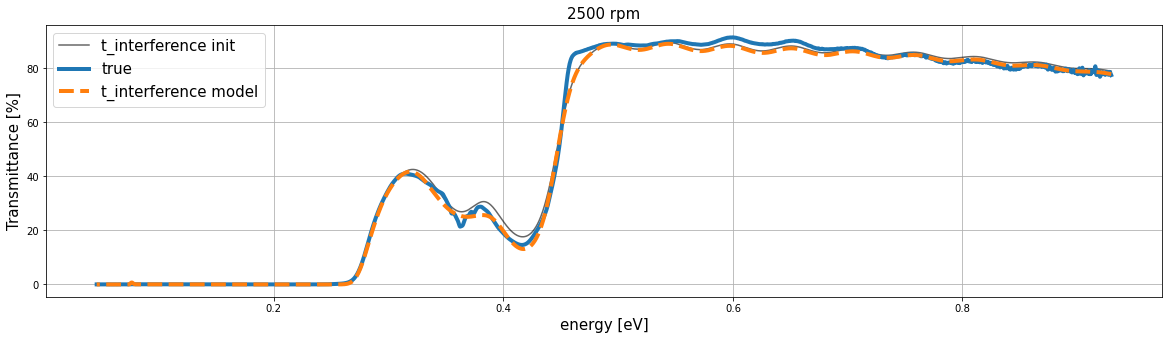

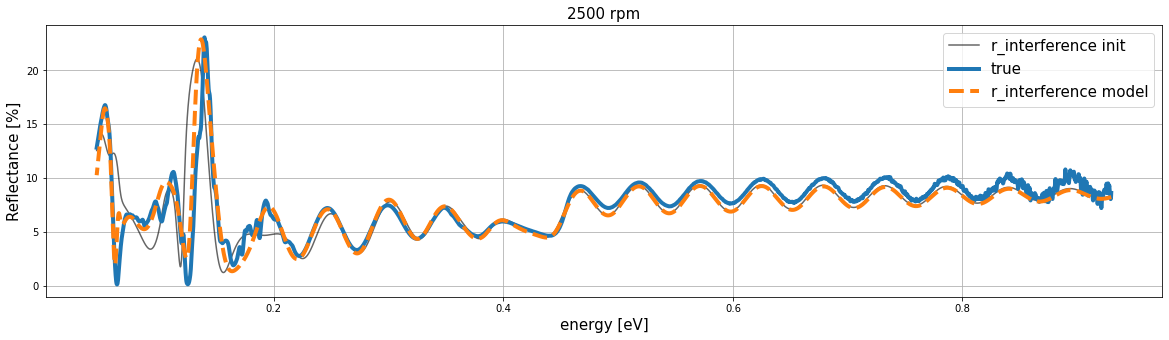

In [12]:
better_inter_params = thin_res.x
better_inter_params[-4:] = np.array(thicknesses[::-1]) *1e-6
arguments = [x]
truth = []

for sample in range(4):
    inter_trans = pd.read_csv(trans_data[sample]).iloc[:,1][:]  / trans_refr.iloc[:,1][:] 
    inter_trans = inter_trans[::parcelation]
    inter_reflx = pd.read_csv(reflx_data[sample]).iloc[:,1][:]  / reflx_refr.iloc[:,1][:] 
    inter_reflx = inter_reflx[::parcelation]
    truth.append([inter_reflx, inter_trans])
    arguments.extend([inter_reflx, inter_trans, thicknesses[sample]*1e-6])

upper_bounds = np.full(len(better_inter_params)-1, np.inf)
lower_bounds = np.zeros(len(better_inter_params)-1)
bounds = [(np.append(lower_bounds,(1e-6))),(np.append(upper_bounds,(0.6)))]


from scipy.optimize import least_squares
better_thin_res = least_squares(fit_both,x0=better_inter_params, args=arguments, max_nfev = 1000, bounds = bounds)
n_rez = sqrt(hobb(better_inter_params[:-3],x)+better_inter_params[-4])

rpms = [1000, 1500, 2000, 2500]


for sample in range(4):
    inter_reflx, inter_trans = truth[sample]

    inter_init = np.append(better_inter_params[:-4], thicknesses[sample]*1e-6)
    inter_fit = np.append(better_thin_res.x[:-4], better_thin_res.x[-sample-1])
    
    fig = plt.figure(figsize=(20,5))
    plt.plot(x, t_substrate(inter_init, x, thicknesses[sample]*1e-6)*100 , label='t_interference init', color='black', alpha=0.6)
    plt.plot(x, inter_trans*100, label='true', linewidth = 4)
    plt.plot(x, t_substrate(inter_fit, x, thicknesses[sample]*1e-6)*100, label = 't_interference model', linestyle = 'dashed', linewidth = 4)
    plt.xlabel('energy [eV]', fontsize = 15)
    plt.ylabel('Transmittance [%]', fontsize = 15)
    plt.title(str(rpms[sample]) + ' rpm', fontsize = 15)
    plt.legend(fontsize=15)
    plt.grid()

    fig = plt.figure(figsize=(20,5))
    plt.plot(x, r_substrate(inter_init, x, thicknesses[sample]*1e-6)*100 , label='r_interference init', color='black', alpha=0.6)
    plt.plot(x, inter_reflx*100, label='true', linewidth = 4)
    plt.plot(x, r_substrate(inter_fit, x, thicknesses[sample]*1e-6)*100, label = 'r_interference model', linestyle = 'dashed', linewidth = 4)
    plt.xlabel('energy [eV]', fontsize = 15)
    plt.ylabel('Reflectance [%]', fontsize = 15)
    plt.title(str(rpms[sample]) + ' rpm', fontsize = 15)
    plt.legend(fontsize=15)
    plt.grid()

data = better_thin_res.x[:-5]

# Display fitted parameters
data = data.reshape(-1, 4)
df = pd.DataFrame(data, columns=["A", "E_0", "$\Gamma$", "$\sigma$"])
pd.set_option('display.float_format', '{:.2e}'.format)
display(df)
print("Ɛ∞ =                  " + str(round(better_thin_res.x[-5], 2)) )

In [13]:
def r_interference(p, energy, d_rez):
    if fit_thickness: d_rez = p[-1]
    epsilon_inf = p[-2]
    n_rez = np.conj(sqrt(hobb(p,energy) + epsilon_inf))
    n_glass = np.sqrt(epsilon)[:len(energy)]
    wavelength = h * c / energy / e
    
    r_01 = (n_rez - 1)/(n_rez+1)
    r_12 = (n_glass - n_rez)/(n_glass+n_rez)
    Reflection = np.square(np.abs((r_01+r_12*exp(-4j*pi/wavelength*n_rez*d_rez))/(1 + r_01*r_12*exp(-4j*pi/wavelength*n_rez*d_rez))))
    return Reflection

def r_interference_back(p, energy, d_rez):
    if fit_thickness: d_rez = p[-1]
    epsilon_inf = p[-2]
    n_rez = np.conj(sqrt(hobb(p,energy) + epsilon_inf))
    n_glass = np.sqrt(epsilon)[:len(energy)]
    wavelength = h * c / energy / e
    
    r_01 = (n_rez - n_glass)/(n_glass+n_rez)
    r_12 = (1 - n_rez)/(n_rez+1)
    Reflection = np.square(np.abs((r_01+r_12*exp(-4j*pi/wavelength*n_rez*d_rez))/(1 + r_01*r_12*exp(-4j*pi/wavelength*n_rez*d_rez))))
    return Reflection

def t_interference(p, energy, d_rez):
    if fit_thickness: d_rez = p[-1]
    epsilon_inf = p[-2]
    n_rez = np.conj(sqrt(hobb(p,energy) + epsilon_inf))
    n_glass = np.sqrt(epsilon)[:len(energy)]
    wavelength = h * c / energy / e
    extinct = imag(n_rez)
    
    r_01 = (1 - n_rez)/(n_rez+1)
    r_12 = (n_rez - n_glass)/(n_glass+n_rez)
    t_01 = 2/(n_rez+1)
    t_12 = 2*n_rez/(n_rez+n_glass)
    
    
    T = np.square(np.abs((t_01*t_12*exp(-2j*pi/wavelength*n_rez*d_rez))/(1 + r_01*r_12*exp(-4j*pi/wavelength*n_rez*d_rez))))
    return T

def t_interference_back(p, energy, d_rez):
    if fit_thickness: d_rez = p[-1]
    epsilon_inf = p[-2]
    n_rez = np.conj(sqrt(hobb(p,energy) + epsilon_inf))
    n_glass = np.sqrt(epsilon)[:len(energy)]
    wavelength = h * c / energy / e
    extinct = imag(n_rez)
    
    r_01 = (1 - n_rez)/(n_rez+1)
    r_12 = (n_rez - n_glass)/(n_glass+n_rez)
    t_01 = 2*n_glass/(n_glass+n_rez)
    t_12 = 2*n_rez/(n_rez+1)
    
    
    T = np.square(np.abs((t_01*t_12*exp(-2j*pi/wavelength*n_rez*d_rez))/(1 + r_01*r_12*exp(-4j*pi/wavelength*n_rez*d_rez))))
    return T

def r_substrate(p, energy, d_rez):
    d_sub = substrate_thickness
    if fit_thickness: d_rez = p[-1]
    epsilon_inf = p[-2]
    n_rez = sqrt(hobb(p,energy) + epsilon_inf)
    
    n_glass = np.sqrt(epsilon)[:len(energy)]
    extinct = np.imag(n_glass)
    wavelength = h * c / energy / e
    
    R_01 = r_interference(p, energy, d_rez)
    R_10 = r_interference_back(p, energy, d_rez)
    R_12 = square(abs((n_glass - 1)/(n_glass + 1)))
    T_01 = t_interference(p, energy, d_rez)
    T_10 = t_interference_back(p, energy, d_rez)
    exponent = exp(-4*pi/wavelength*extinct*d_sub)
    
    return R_01 + T_01*R_12*T_10*exponent/(1-R_12*R_10*exponent)

def t_substrate(p, energy, d_rez):
    d_sub = substrate_thickness
    if fit_thickness: d_rez = p[-1]
    epsilon_inf = p[-2]
    n_rez = sqrt(hobb(p,energy) + epsilon_inf)
    
    wavelength = h * c / energy / e
    n_glass = np.sqrt(epsilon)[:len(energy)]
    extinct = np.imag(n_glass)
    
    R_10 = r_interference_back(p, energy, d_rez)
    R_12 = square(abs((n_glass - 1)/(n_glass + 1)))
    T_01 = t_interference(p, energy, d_rez)
    T_12 = square(abs(2*n_glass/(1+n_glass)))
    exponent1 = exp(-4*pi/wavelength*extinct*d_sub)
    exponent2 = exp(-8*pi/wavelength*extinct*d_sub)
    
    Trans = T_01*T_12*exponent1/(1-R_12*R_10*exponent2)
    return Trans

def fit_both(p, energy, R1, T1, d1, R2, T2, d2, R3, T3, d3, R4, T4, d4, ):
    p1 = np.append(p[:-4], p[-4])
    p2 = np.append(p[:-4], p[-3])
    p3 = np.append(p[:-4], p[-2])
    p4 = np.append(p[:-4], p[-1])
    Rdiff1 = r_substrate(p1, energy, d1, fit_thickness) - R1
    Tdiff1 = t_substrate(p1, energy, d1, fit_thickness) - T1
    Rdiff2 = r_substrate(p2, energy, d2, fit_thickness) - R2
    Tdiff2 = t_substrate(p2, energy, d2, fit_thickness) - T2
    Rdiff3 = r_substrate(p3, energy, d3, fit_thickness) - R3
    Tdiff3 = t_substrate(p3, energy, d3, fit_thickness) - T3
    Rdiff4 = r_substrate(p4, energy, d4, fit_thickness) - R4
    Tdiff4 = t_substrate(p4, energy, d4, fit_thickness) - T4
    both = np.concatenate((Tdiff1, Rdiff1, Tdiff2, Rdiff2, Tdiff3, Rdiff3, Tdiff4, Rdiff4))
    return both